In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

In [3]:
url = "https://catalog.data.gov/dataset/air-quality-measures-on-the-national-environmental-health-tracking-network"
response = requests.get(url)
html_content = response.text

In [4]:
soup = BeautifulSoup(html_content, 'html.parser')


In [5]:
download_link = soup.find('a', class_="btn btn-primary", attrs={"data-format": "csv"})
download_url = download_link['href'] if download_link else None
# Check if the download URL is found
if download_url:

    # Make a GET request to download the file
    response = requests.get(download_url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:

         # Open a local file for writing with the same name as on the server
        with open('EV_POP.csv', 'wb') as file:
            for line in response.iter_content(chunk_size=128):
                file.write(line)
        print("File downloaded successfully!")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully!


In [6]:
url = "https://catalog.data.gov/dataset/electric-vehicle-population-data"
response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')



download_link = soup.find('a', class_="btn btn-primary", attrs={"data-format": "csv"})
download_url = download_link['href'] if download_link else None
# Check if the download URL is found
if download_url:

    # Make a GET request to download the file
    response = requests.get(download_url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:

         # Open a local file for writing with the same name as on the server
        with open('AQI.csv', 'wb') as file:
            for line in response.iter_content(chunk_size=128):
                file.write(line)
        print("File downloaded successfully!")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully!


In [7]:
import pandas as pd

# Load the datasets
df_aqi = pd.read_csv('EV_POP.csv')
df_ev = pd.read_csv("AQI.csv")

# Clean the AQI DataFrame
df_aqi_cleaned = df_aqi.rename(columns={
    'StateFips': 'StateFips_AQI', 
    'CountyFips': 'CountyFips_AQI'
})


In [8]:
df_aqi_cleaned = df_aqi_cleaned.dropna()

df_ev_cleaned = df_ev.rename(columns={
    'VIN (1-10)': 'VIN',
    'Postal Code': 'PostalCode'
})



df_ev_cleaned['Model Year'] = df_ev_cleaned['Model Year'].astype(int)
df_ev_cleaned['Base MSRP'] = df_ev_cleaned['Base MSRP'].astype(float)
df_ev_cleaned['Electric Range'] = df_ev_cleaned['Electric Range'].astype(int)

df_ev_cleaned = df_ev_cleaned.dropna()

df_ev_cleaned['PostalCode'] = df_ev_cleaned['PostalCode'].astype(int)



In [9]:
df_ev_cleaned.describe()

,PostalCode,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,159101.000000,159101.000000,159101.000000,159101.000000,159101.000000,1.591010e+05,1.591010e+05
mean,98259.349118,2020.194260,64.271211,1224.902892,29.261997,2.140532e+08,5.303974e+10
std,302.994561,3.010348,94.630664,8918.602487,14.844000,7.959567e+07,1.618356e+07
min,98001.000000,1997.000000,0.000000,0.000000,1.000000,4.385000e+03,5.300195e+10
25%,98052.000000,2018.000000,0.000000,0.000000,18.000000,1.733524e+08,5.303301e+10
50%,98122.000000,2021.000000,14.000000,0.000000,33.000000,2.199006e+08,5.303303e+10
75%,98370.000000,2023.000000,84.000000,0.000000,43.000000,2.448453e+08,5.305307e+10
max,99403.000000,2024.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.307794e+10


In [10]:

columns_to_check = ['PostalCode', 'Model Year', 'Electric Range', 'Base MSRP',  '2020 Census Tract']
df_ev_cleaned = df_ev_cleaned.drop(columns='Legislative District')
msrp_per_model = df_ev_cleaned[df_ev_cleaned['Base MSRP'] != 0].groupby('Model')['Base MSRP'].median()
for model, msrp in msrp_per_model.items():
    df_ev_cleaned.loc[(df_ev_cleaned['Model'] == model) & (df_ev_cleaned['Base MSRP'] == 0), 'Base MSRP'] = msrp

df_ev_cleaned = df_ev_cleaned[~(df_ev_cleaned[columns_to_check] == 0).any(axis=1)]

In [11]:


# Ensure the correct data types
df_aqi_cleaned['MeasureId'] = df_aqi_cleaned['MeasureId'].astype(int)
df_aqi_cleaned['ReportYear'] = df_aqi_cleaned['ReportYear'].astype(int)
df_aqi_cleaned['Value'] = df_aqi_cleaned['Value'].astype(float)
# Repeat for other columns as per your schema


In [12]:
df_aqi_cleaned['MonitorOnly'] = df_aqi_cleaned['MonitorOnly'].astype(bool)


In [13]:

columns_to_check = ['Unit']

df_aqi_cleaned_unit = df_aqi_cleaned[~(df_aqi_cleaned[columns_to_check] == '%').any(axis=1)]
df_aqi_cleaned_unit = df_aqi_cleaned_unit[~(df_aqi_cleaned_unit[columns_to_check] == 'No Units').any(axis=1)]

In [14]:
df_aqi_cleaned_unit.count()

MeasureId              42621
MeasureName            42621
MeasureType            42621
StratificationLevel    42621
StateFips_AQI          42621
StateName              42621
CountyFips_AQI         42621
CountyName             42621
ReportYear             42621
Value                  42621
Unit                   42621
UnitName               42621
DataOrigin             42621
MonitorOnly            42621
dtype: int64

In [15]:
df_aqi_cleaned_percent = df_aqi_cleaned[~(df_aqi_cleaned[columns_to_check] == 'µg/m³').any(axis=1)]
df_aqi_cleaned_percent = df_aqi_cleaned_percent[~(df_aqi_cleaned_percent[columns_to_check] == 'No Units').any(axis=1)]
df_aqi_cleaned_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43467 entries, 49 to 150236
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MeasureId            43467 non-null  int64  
 1   MeasureName          43467 non-null  object 
 2   MeasureType          43467 non-null  object 
 3   StratificationLevel  43467 non-null  object 
 4   StateFips_AQI        43467 non-null  int64  
 5   StateName            43467 non-null  object 
 6   CountyFips_AQI       43467 non-null  int64  
 7   CountyName           43467 non-null  object 
 8   ReportYear           43467 non-null  int64  
 9   Value                43467 non-null  float64
 10  Unit                 43467 non-null  object 
 11  UnitName             43467 non-null  object 
 12  DataOrigin           43467 non-null  object 
 13  MonitorOnly          43467 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(8)
memory usage: 4.7+ MB


In [16]:
df_aqi_cleaned_percent.head()

,MeasureId,MeasureName,MeasureType,StratificationLevel,StateFips_AQI,StateName,CountyFips_AQI,CountyName,ReportYear,Value,Unit,UnitName,DataOrigin,MonitorOnly
49,85,Percent of days with PM2.5 levels over the Nat...,Percent,State x County,40,Oklahoma,40143,Tulsa,1999,0.0,%,Percent,Monitor Only,True
74,85,Percent of days with PM2.5 levels over the Nat...,Percent,State x County,39,Ohio,39151,Stark,2013,0.0,%,Percent,Monitor Only,True
320,85,Percent of days with PM2.5 levels over the Nat...,Percent,State x County,35,New Mexico,35025,Lea,2002,0.0,%,Percent,Monitor Only,True
345,85,Percent of days with PM2.5 levels over the Nat...,Percent,State x County,48,Texas,48037,Bowie,2003,0.0,%,Percent,Monitor Only,True
395,85,Percent of days with PM2.5 levels over the Nat...,Percent,State x County,4,Arizona,4003,Cochise,2007,0.0,%,Percent,Monitor Only,True


In [17]:
df_ev_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13555 entries, 0 to 159464
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   VIN                                                13555 non-null  object 
 1   County                                             13555 non-null  object 
 2   City                                               13555 non-null  object 
 3   State                                              13555 non-null  object 
 4   PostalCode                                         13555 non-null  int64  
 5   Model Year                                         13555 non-null  int64  
 6   Make                                               13555 non-null  object 
 7   Model                                              13555 non-null  object 
 8   Electric Vehicle Type                              13555 non-null  object 
 9   Clean

In [18]:
df_ev_cleaned.head()

,VIN,County,City,State,PostalCode,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,2C4RC1N71H,Kitsap,Bremerton,WA,98311,2017,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,33,39995.0,349437882,POINT (-122.6466274 47.6341188),PUGET SOUND ENERGY INC,5.303509e+10
1,2C4RC1N7XL,Stevens,Colville,WA,99114,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,39995.0,154690532,POINT (-117.90431 48.547075),AVISTA CORP,5.306595e+10
6,WMZYU7C51K,Yakima,Yakima,WA,98902,2019,MINI,COUNTRYMAN,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,12,36900.0,146830148,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10
14,5YJSA1E21J,Island,Clinton,WA,98236,2018,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249,69900.0,476056199,POINT (-122.359364 47.9796552),PUGET SOUND ENERGY INC,5.302997e+10
15,YV4BR0CL3N,Snohomish,Bothell,WA,98021,2022,VOLVO,XC90,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,18,64950.0,194401833,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10


In [19]:
df_ev_cleaned = df_ev_cleaned.dropna(subset=['State'])
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Apply this mapping to the 'State' column in df_ev_cleaned
df_ev_cleaned['State'] = df_ev_cleaned['State'].map(state_abbrev_to_name)

In [20]:
print(df_ev_cleaned[['State', 'County']].head())

         State     County
0   Washington     Kitsap
1   Washington    Stevens
6   Washington     Yakima
14  Washington     Island
15  Washington  Snohomish


In [21]:
merged_df1 = pd.merge(df_aqi_cleaned_percent, df_ev_cleaned, 
                     left_on=['StateName', 'CountyName'], 
                     right_on=['State', 'County'])

In [25]:
print(merged_df1.columns)

Index(['MeasureId', 'MeasureName', 'MeasureType', 'StratificationLevel',
       'StateFips_AQI', 'StateName', 'CountyFips_AQI', 'CountyName',
       'ReportYear', 'Value', 'Unit', 'UnitName', 'DataOrigin', 'MonitorOnly',
       'VIN', 'County', 'City', 'State', 'PostalCode', 'Model Year', 'Make',
       'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility',
       '2020 Census Tract'],
      dtype='object')


In [22]:
print(df_aqi_cleaned_percent['StateName'].value_counts())
print(df_ev_cleaned['State'].value_counts())

Texas                   3085
Georgia                 2045
Virginia                1727
Kentucky                1594
North Carolina          1555
Missouri                1422
Illinois                1399
Indiana                 1305
Iowa                    1297
Ohio                    1287
Tennessee               1280
Kansas                  1245
California              1215
Michigan                1192
Nebraska                1136
Minnesota               1106
Mississippi             1101
Wisconsin               1057
Pennsylvania            1043
Arkansas                1042
Florida                 1033
Oklahoma                1025
Alabama                  988
New York                 961
Colorado                 913
Louisiana                904
South Dakota             816
West Virginia            797
Montana                  752
South Carolina           686
North Dakota             662
Idaho                    632
Washington               585
Oregon                   585
New Mexico    

In [23]:
merged_df1.describe()



,MeasureId,StateFips_AQI,CountyFips_AQI,ReportYear,Value,PostalCode,Model Year,Electric Range,Base MSRP,DOL Vehicle ID,2020 Census Tract
count,322447.000000,322447.0,322447.000000,322447.000000,322447.000000,322447.000000,322447.000000,322447.000000,322447.000000,3.224470e+05,3.224470e+05
mean,181.645170,53.0,53038.769370,2005.839490,1.047658,98234.066774,2018.254076,119.176426,59745.727112,2.105001e+08,5.303884e+10
std,104.204536,0.0,14.854224,3.840538,1.238507,292.998124,3.121778,101.023622,20183.189656,9.361217e+07,1.487126e+07
min,85.000000,53.0,53001.000000,1999.000000,0.000000,98001.000000,2008.000000,12.000000,31950.000000,8.981300e+04,5.300195e+10
25%,85.000000,53.0,53033.000000,2003.000000,0.000000,98042.000000,2016.000000,32.000000,39995.000000,1.508403e+08,5.303301e+10
50%,85.000000,53.0,53033.000000,2006.000000,0.547945,98115.000000,2018.000000,35.000000,64950.000000,2.047644e+08,5.303303e+10
75%,294.000000,53.0,53053.000000,2009.000000,1.369863,98321.000000,2021.000000,210.000000,69900.000000,2.456647e+08,5.305307e+10
max,294.000000,53.0,53077.000000,2013.000000,16.666667,99403.000000,2024.000000,337.000000,845000.000000,4.788667e+08,5.307794e+10


In [24]:
merged_df2 = pd.merge(df_aqi_cleaned_unit, df_ev_cleaned, 
                     left_on=['StateName', 'CountyName'], 
                     right_on=['State', 'County'])
merged_df2.

TypeError: 'Index' object is not callable

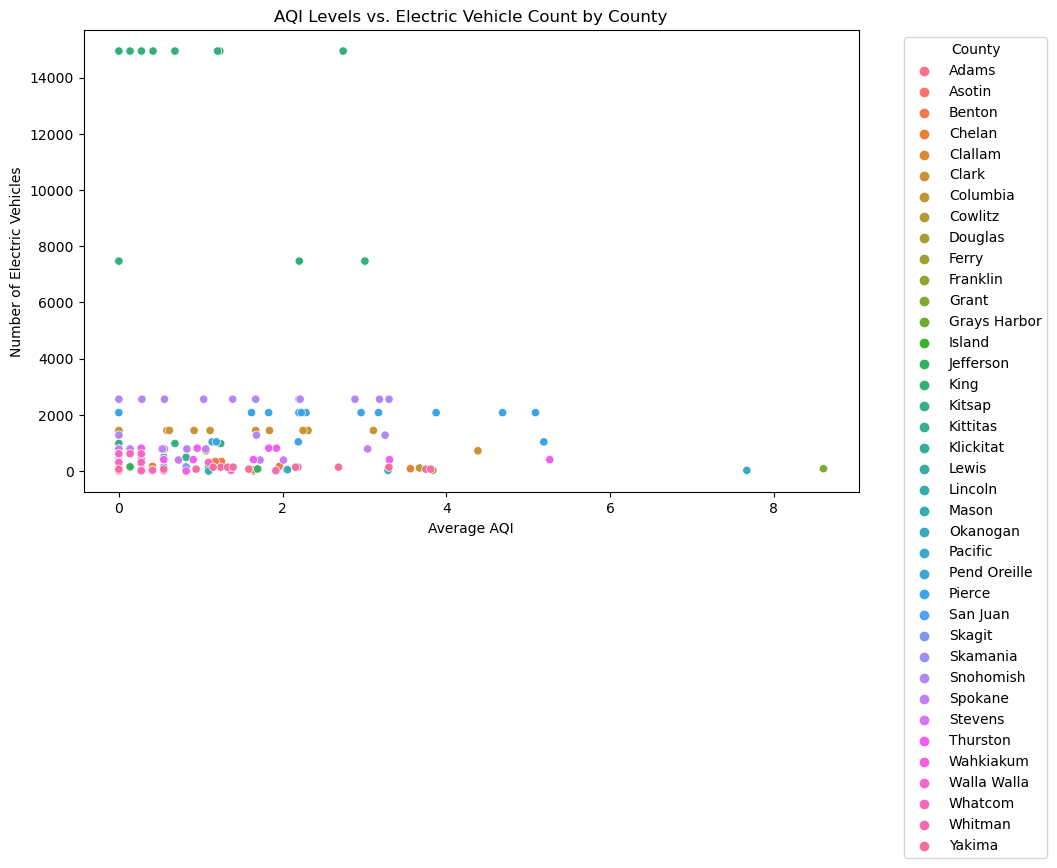

In [ ]:
#This plot can help visualize if there's a correlation between AQI levels and the adoption of electric vehicles in different counties.

import matplotlib.pyplot as plt
import seaborn as sns

# Group data by County and ReportYear, calculate average AQI and count of EVs
grouped_data = merged_df1.groupby(['CountyName', 'ReportYear']).agg(avg_aqi=('Value', 'mean'), 
                                                                    ev_count=('VIN', 'count')).reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='avg_aqi', y='ev_count', hue='CountyName')
plt.title('AQI Levels vs. Electric Vehicle Count by County')
plt.xlabel('Average AQI')
plt.ylabel('Number of Electric Vehicles')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('1')
plt.show()


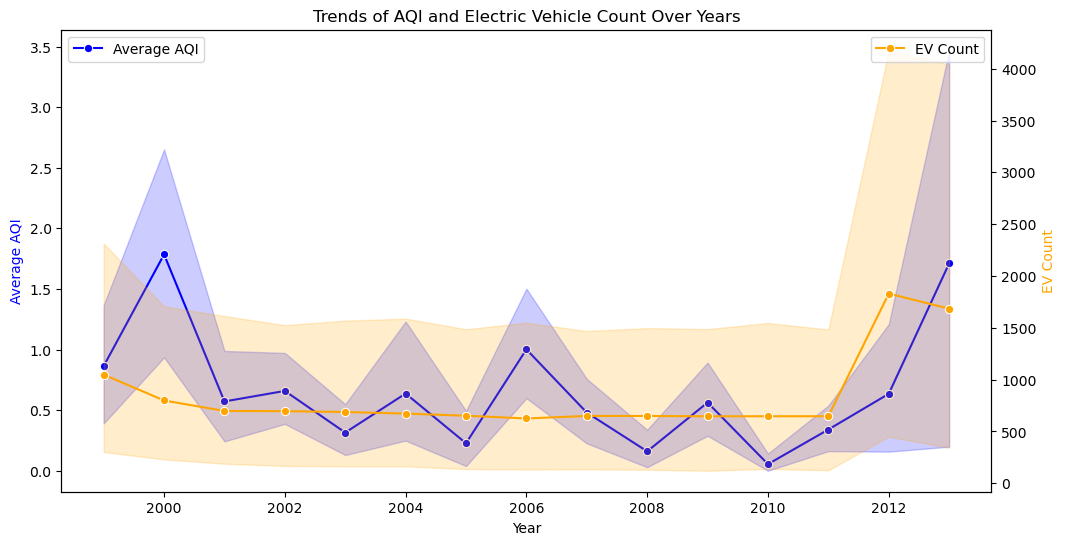

In [ ]:
# Plotting time series data
#This plot can show trends over time in a particular county or statewide.
plt.figure(figsize=(12, 6))

ax = plt.gca()
ax2 = ax.twinx()

sns.lineplot(data=grouped_data, x='ReportYear', y='avg_aqi', marker='o', label='Average AQI', ax=ax, color='blue')


sns.lineplot(data=grouped_data, x='ReportYear', y='ev_count', marker='o', label='EV Count', ax=ax2, color='orange')

ax.set_title('Trends of AQI and Electric Vehicle Count Over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Average AQI', color='blue')
ax2.set_ylabel('EV Count', color='orange')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

"""
we're exploring the relationship between air quality, as measured by the Average AQI, 
and the adoption of electric vehicles over time. The blue line represents the Average AQI 
for each year. The goal is to determine whether increased EV adoption correlates 
with improved air quality, which is expected but not yet visible in this plot
"""


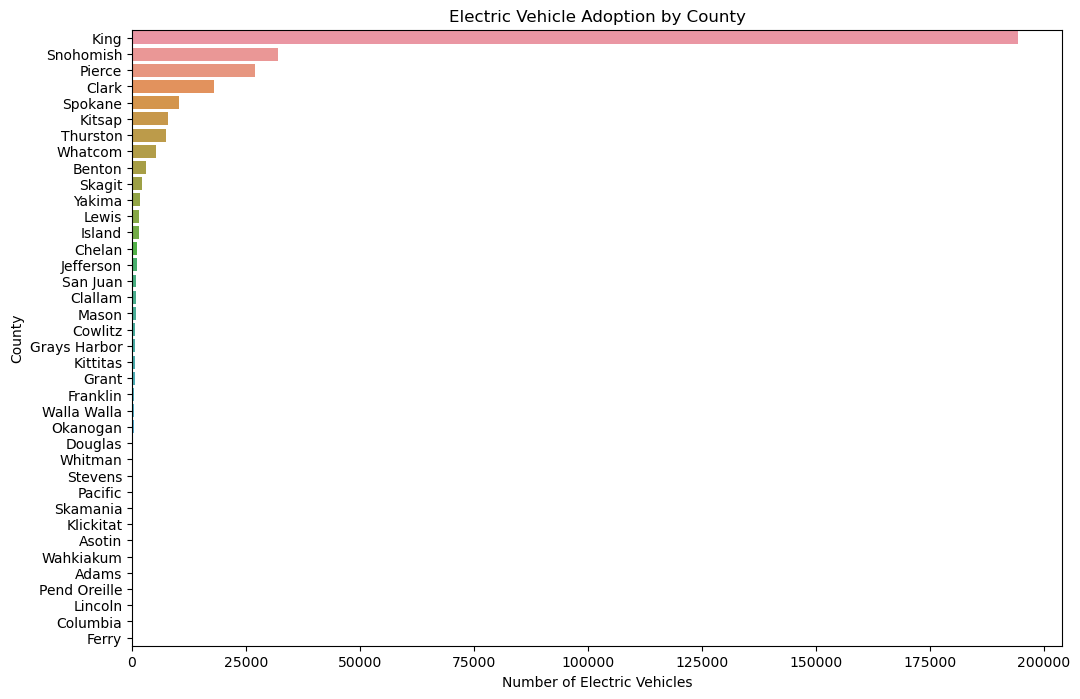

In [ ]:
# Summarize EV count by County
county_ev_counts = merged_df1.groupby('CountyName')['VIN'].count().sort_values(ascending=False)

# Bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=county_ev_counts.values, y=county_ev_counts.index)
plt.title('Electric Vehicle Adoption by County')
plt.xlabel('Number of Electric Vehicles')
plt.ylabel('County')
plt.savefig('3')
plt.show()


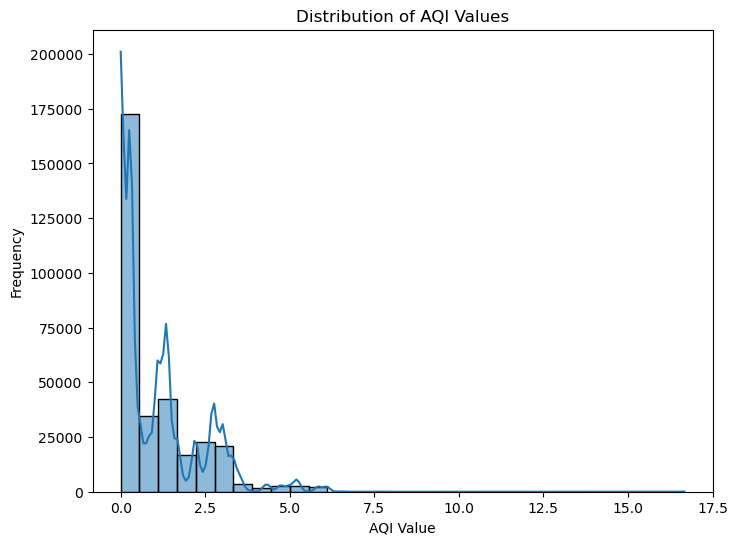

In [ ]:
# Histogram of AQI values
plt.figure(figsize=(8, 6))
sns.histplot(merged_df1['Value'], bins=30, kde=True)
plt.title('Distribution of AQI Values')
plt.xlabel('AQI Value')
plt.ylabel('Frequency')
plt.savefig('4')
plt.show()


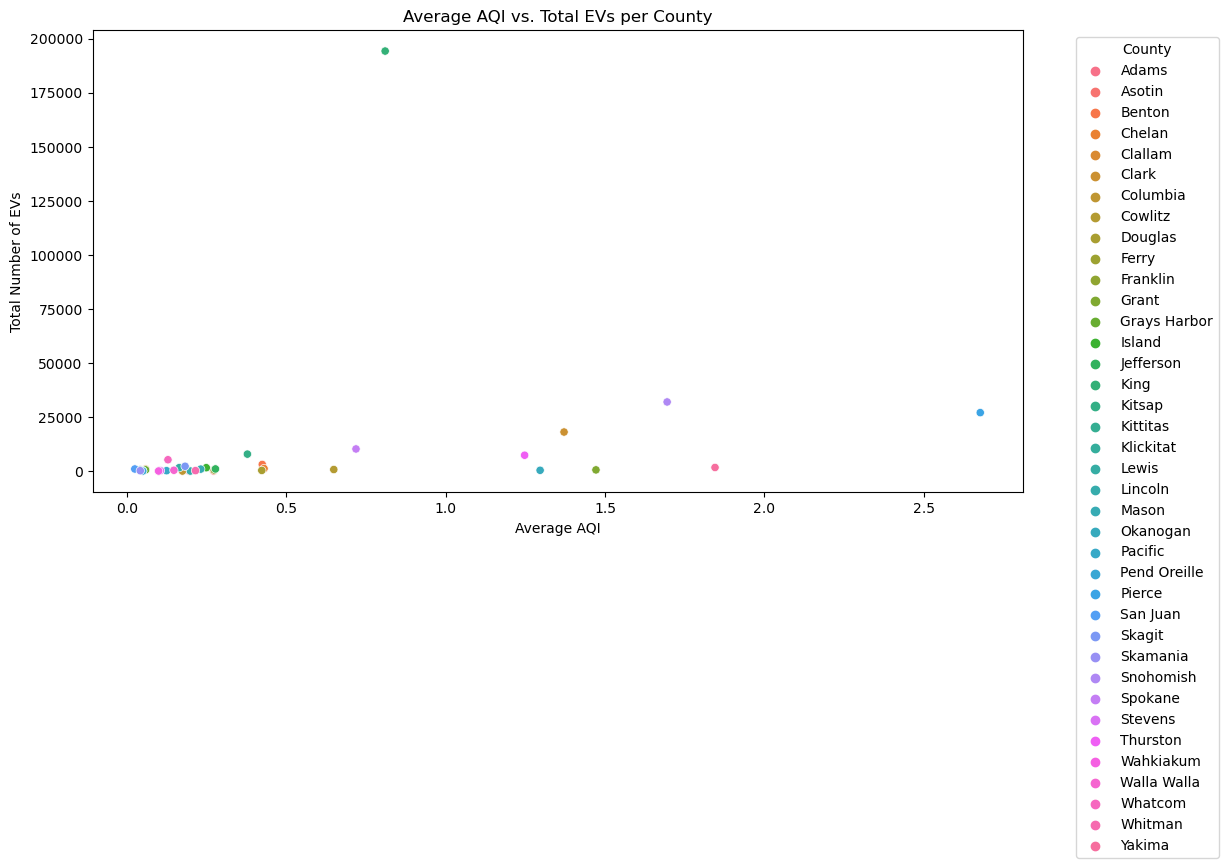

In [ ]:
county_data = merged_df1.groupby('CountyName').agg(
    avg_aqi=('Value', 'mean'),
    total_evs=('VIN', 'count')
).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=county_data, x='avg_aqi', y='total_evs', hue='CountyName')
plt.title('Average AQI vs. Total EVs per County')
plt.xlabel('Average AQI')
plt.ylabel('Total Number of EVs')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('5')
plt.show()


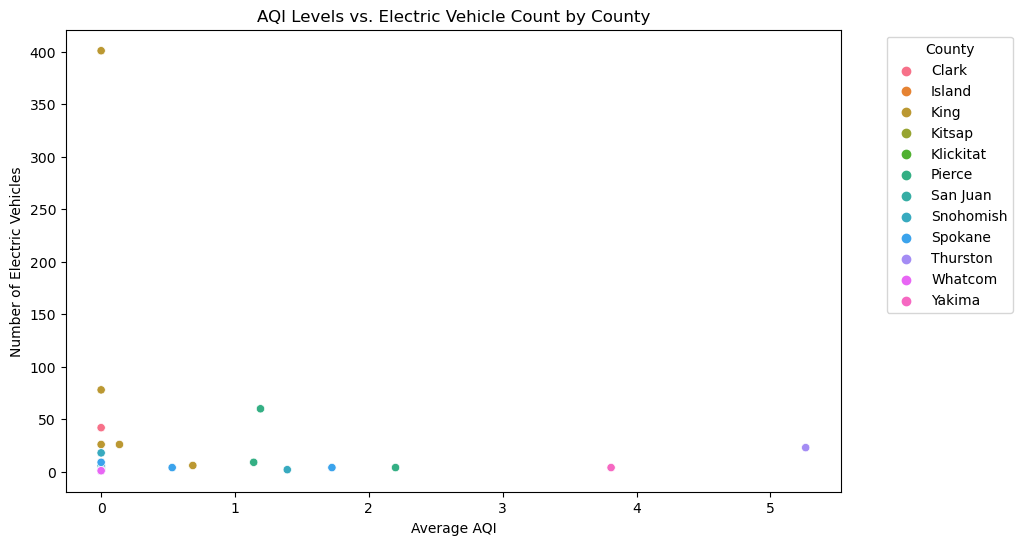

In [ ]:
#This plot can help visualize if there's a correlation between AQI levels and the adoption of electric vehicles in different counties.

import matplotlib.pyplot as plt
import seaborn as sns

# Group data by County and ReportYear, calculate average AQI and count of EVs
grouped_data1 = merged_df2.groupby(['CountyName', 'ReportYear']).agg(avg_aqi=('Value', 'mean'), 
                                                                    ev_count=('VIN', 'count')).reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='avg_aqi', y='ev_count', hue='CountyName')
plt.title('AQI Levels vs. Electric Vehicle Count by County')
plt.xlabel('Average AQI')
plt.ylabel('Number of Electric Vehicles')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('1a')
plt.show()

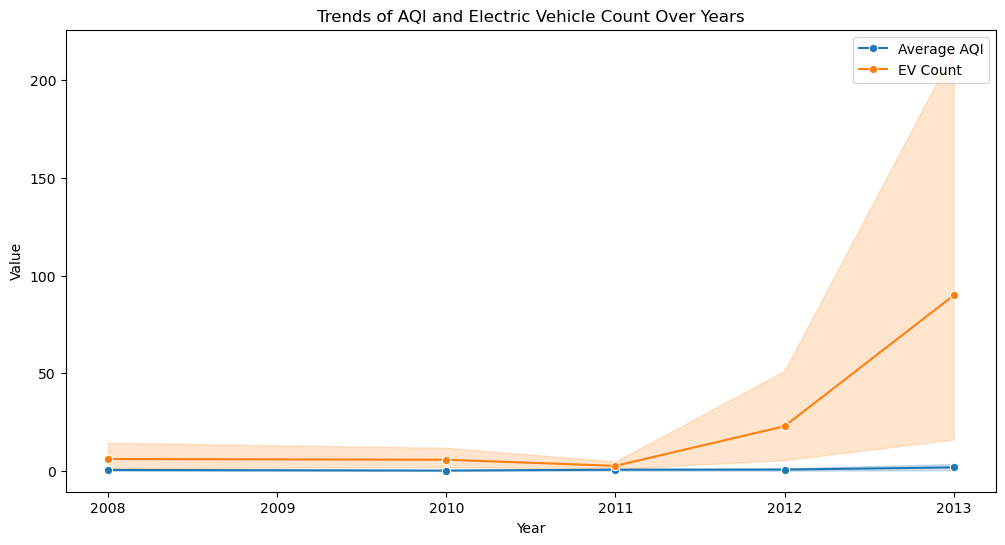

In [ ]:
# Plotting time series data
#This plot can show trends over time in a particular county or statewide.
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='ReportYear', y='avg_aqi', marker='o', label='Average AQI')
sns.lineplot(data=grouped_data, x='ReportYear', y='ev_count', marker='o', label='EV Count')
plt.title('Trends of AQI and Electric Vehicle Count Over Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.savefig('2')
plt.show()

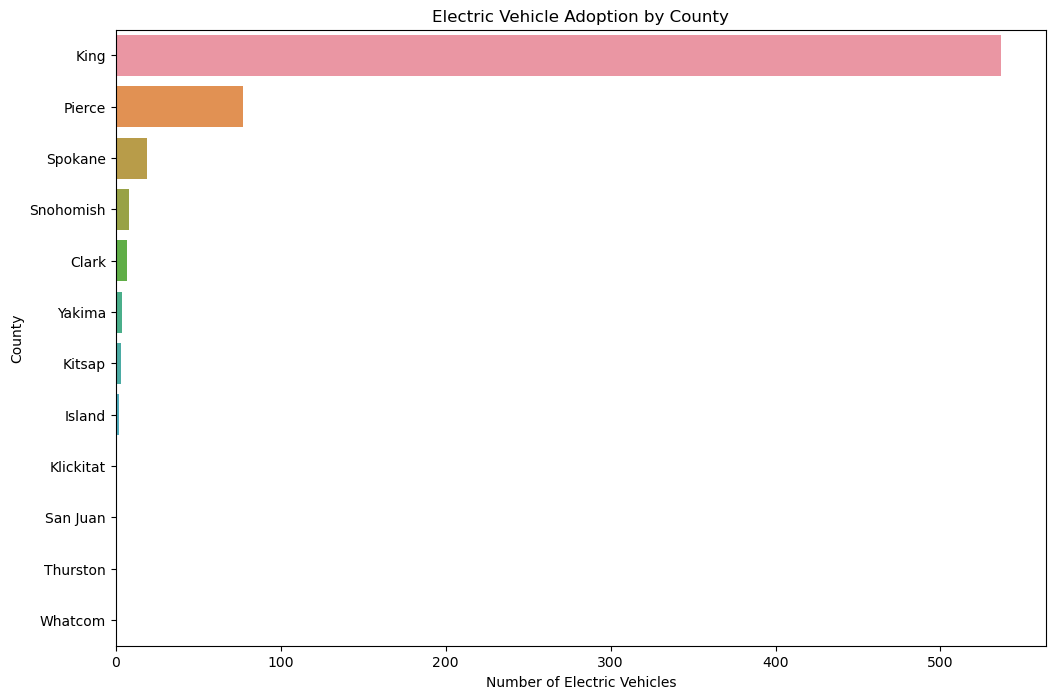

In [ ]:
# Summarize EV count by County
county_ev_counts = merged_df2.groupby('CountyName')['VIN'].count().sort_values(ascending=False)

# Bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=county_ev_counts.values, y=county_ev_counts.index)
plt.title('Electric Vehicle Adoption by County')
plt.xlabel('Number of Electric Vehicles')
plt.ylabel('County')
plt.savefig('3')
plt.show()


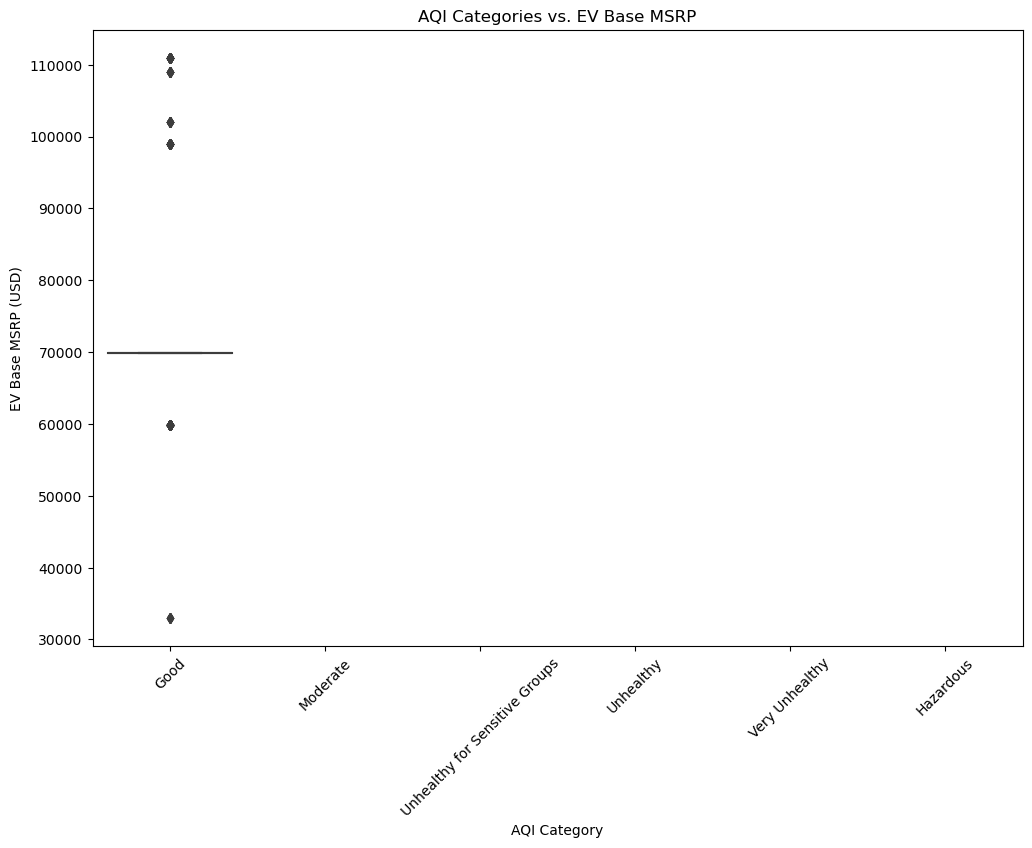

In [ ]:
# Assuming 'Value' is the AQI value, let's bin them into categories
bins = [0, 50, 100, 150, 200, 300, 500] # AQI categories like Good, Moderate, Unhealthy, etc.
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
merged_df2['AQI_Category'] = pd.cut(merged_df2['Value'], bins=bins, labels=labels, include_lowest=True)

# Now let's try the boxplot again with the binned AQI values
plt.figure(figsize=(12, 8))
sns.boxplot(x='AQI_Category', y='Base MSRP', data=merged_df1)
plt.title('AQI Categories vs. EV Base MSRP')
plt.xlabel('AQI Category')
plt.ylabel('EV Base MSRP (USD)')
plt.xticks(rotation=45) # Rotate the x-axis labels for better readability
plt.savefig('6.png')
plt.show()
